Custom code for demographic inference / fastsimcoal modelling in: <br>

Comeault et al. (2021). Genomic signatures of admixture and selection are shared among populations of Zaprionus indianus across the western hemisphere. Mol. Ecol. <br>

Written by Andi Kautt in 2020/2021<br>

I highly recommend installing https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/ and turning the TOC option on

## Set up environment

### Load modules

In [4]:
import sys,os,re,fnmatch,glob,shutil,pickle,itertools
import subprocess
import numpy as np
import pandas as pd

### Define functions

Create two convenient functions to write and submit scripts to scheduler and track / retrieve status of job IDs (written for SLURM, but could easily be adapted for use with SGE)

In [2]:
# change accordingly
username = 'akautt'

# create dictionary to catch job IDs for all jobs submitted by function below
slurm_ids = {} 

# code adapted from function written by Brock Wooldridge
def make_slurm(cmd_string,jobName,echo=False,run=False,write=True,mem='2gb',time='00-12:00',N='1',n='1',c='1',
               array='1-1%1',p='shared'):
    SLURM = ('''#!/bin/bash\n'''
           '''#SBATCH -N {nodes}\n'''
           '''#SBATCH -n {tasks}\n'''
           '''#SBATCH -c {cpus}\n'''
           '''#SBATCH -t {time}\n'''
           '''#SBATCH --mem={mem}\n'''
           '''#SBATCH -p {partition}\n'''
           '''#SBATCH --array {array}\n'''
           '''#SBATCH --job-name {jobName}\n'''
           '''#SBATCH -e {log_dir}/%x_%A_%a.out\n'''
           '''#SBATCH -o {log_dir}/%x_%A_%a.out\n'''
           '''{cmd_string}\n''').format(
                jobName=jobName,cmd_string=cmd_string,partition=p,time=time,mem=mem,tasks=n,cpus=c,nodes=N,
                array=array,log_dir=log_dir)

    # Show SLURM command?
    if echo == True:
        print(SLURM)

    # Write to file and/or submit to SLURM?
    if write == True:
        filename = '%s/%s.slurm' % (scripts_dir,jobName)
        with open(filename, 'w') as outfile:
            outfile.write(SLURM)
            print('"%s" slurm script written to %s\n' %(jobName, scripts_dir))
        # Run
        if run == True:
            sbatch_response = subprocess.getoutput('sbatch {}'.format(filename))
            print(sbatch_response)
            job_id = sbatch_response.split(' ')[-1].strip()
            slurm_ids[jobName] = job_id
            
    return(SLURM)

def sacct_extract(job_name):
    
    jobstring = ','.join( jobID for name,jobID in slurm_ids.items() if job_name in name )

    sacct_out = [ subprocess.getoutput('sacct -j {}'.format(jobstring)) ]

    output = []
    for line in sacct_out:
        jobs = line.split("\n")
        for entry in jobs:
            if username in entry:
                fields = entry.split()
                output.append(fields[0:9])
    print(*output,sep="\n")

### Set up main dirs

In [5]:
project = 'Zindianus_WGS'
stem_path = '/Users/akautt/projects/'
project_dir = stem_path + project

# create main folders for project
if not os.path.exists(project_dir):
    os.mkdir(project_dir)
fsc_dir = os.path.join(project_dir,'data_wHWEfilter')
if not os.path.exists(fsc_dir):
    os.mkdir(fsc_dir)
scripts_dir = os.path.join(project_dir,'scripts')
if not os.path.exists(scripts_dir):
    os.mkdir(scripts_dir)
log_dir = os.path.join(scripts_dir,'logs')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

## three-pop models

### Set up pop info

Create folder and set population names and allele sizes per pop

In [8]:
pops = 'st_zam_usa'

if not os.path.exists(os.path.join(fsc_dir, pops)):
    os.mkdir(os.path.join(fsc_dir, pops))
    
pop1,pop2,pop3 = pops.split('_')

# pop size in no. alleles
pop_size = {}

pop_size[pop1] = 12
pop_size[pop2] = 12
pop_size[pop3] = 48

### Make SFS comaptible with fsc

Assumes that joint site frequency spectrum (SFS) was generated with ANGSD and realSFS (multi-SFS format). Corrects number of monomorphic sites (there can be no derived sites that are fixed in all three populations) and adds header

In [8]:
in_SFS = os.path.join(fsc_dir, pops, 'zind_ST_ZAM_USA_wHWEfilters.ml.sfs')

out_SFS = '{}/{}/{}_DSFS.obs'.format(fsc_dir,pops,pops)

# load sfs, and add fixed, derived entries to monomorphic class
sfs = np.loadtxt(in_SFS)

sfs[0] = sfs[0] + sfs[-1]
sfs[-1] = 0

# add header for fsc and save to file
if not os.path.exists(out_SFS):
    with open(out_SFS, 'w') as outhandle:
        print('1 observation', '\n', '3 ', pop_size[pop1], ' ', pop_size[pop2], ' ', pop_size[pop3], '\n', 
            sep='', file=outhandle)
        print(*sfs.round(3), sep=' ', file=outhandle)

### Create tpl and est files

These are the models we want to simulate/test. Essentially, we want to test the same eight different scenarios (A-H) with three different population size change variations (constant, allgrowth, or AFRchangeUSAgrowthchange) <br>

Create/write .tpl and .est fastsimcoal files below for each scenario

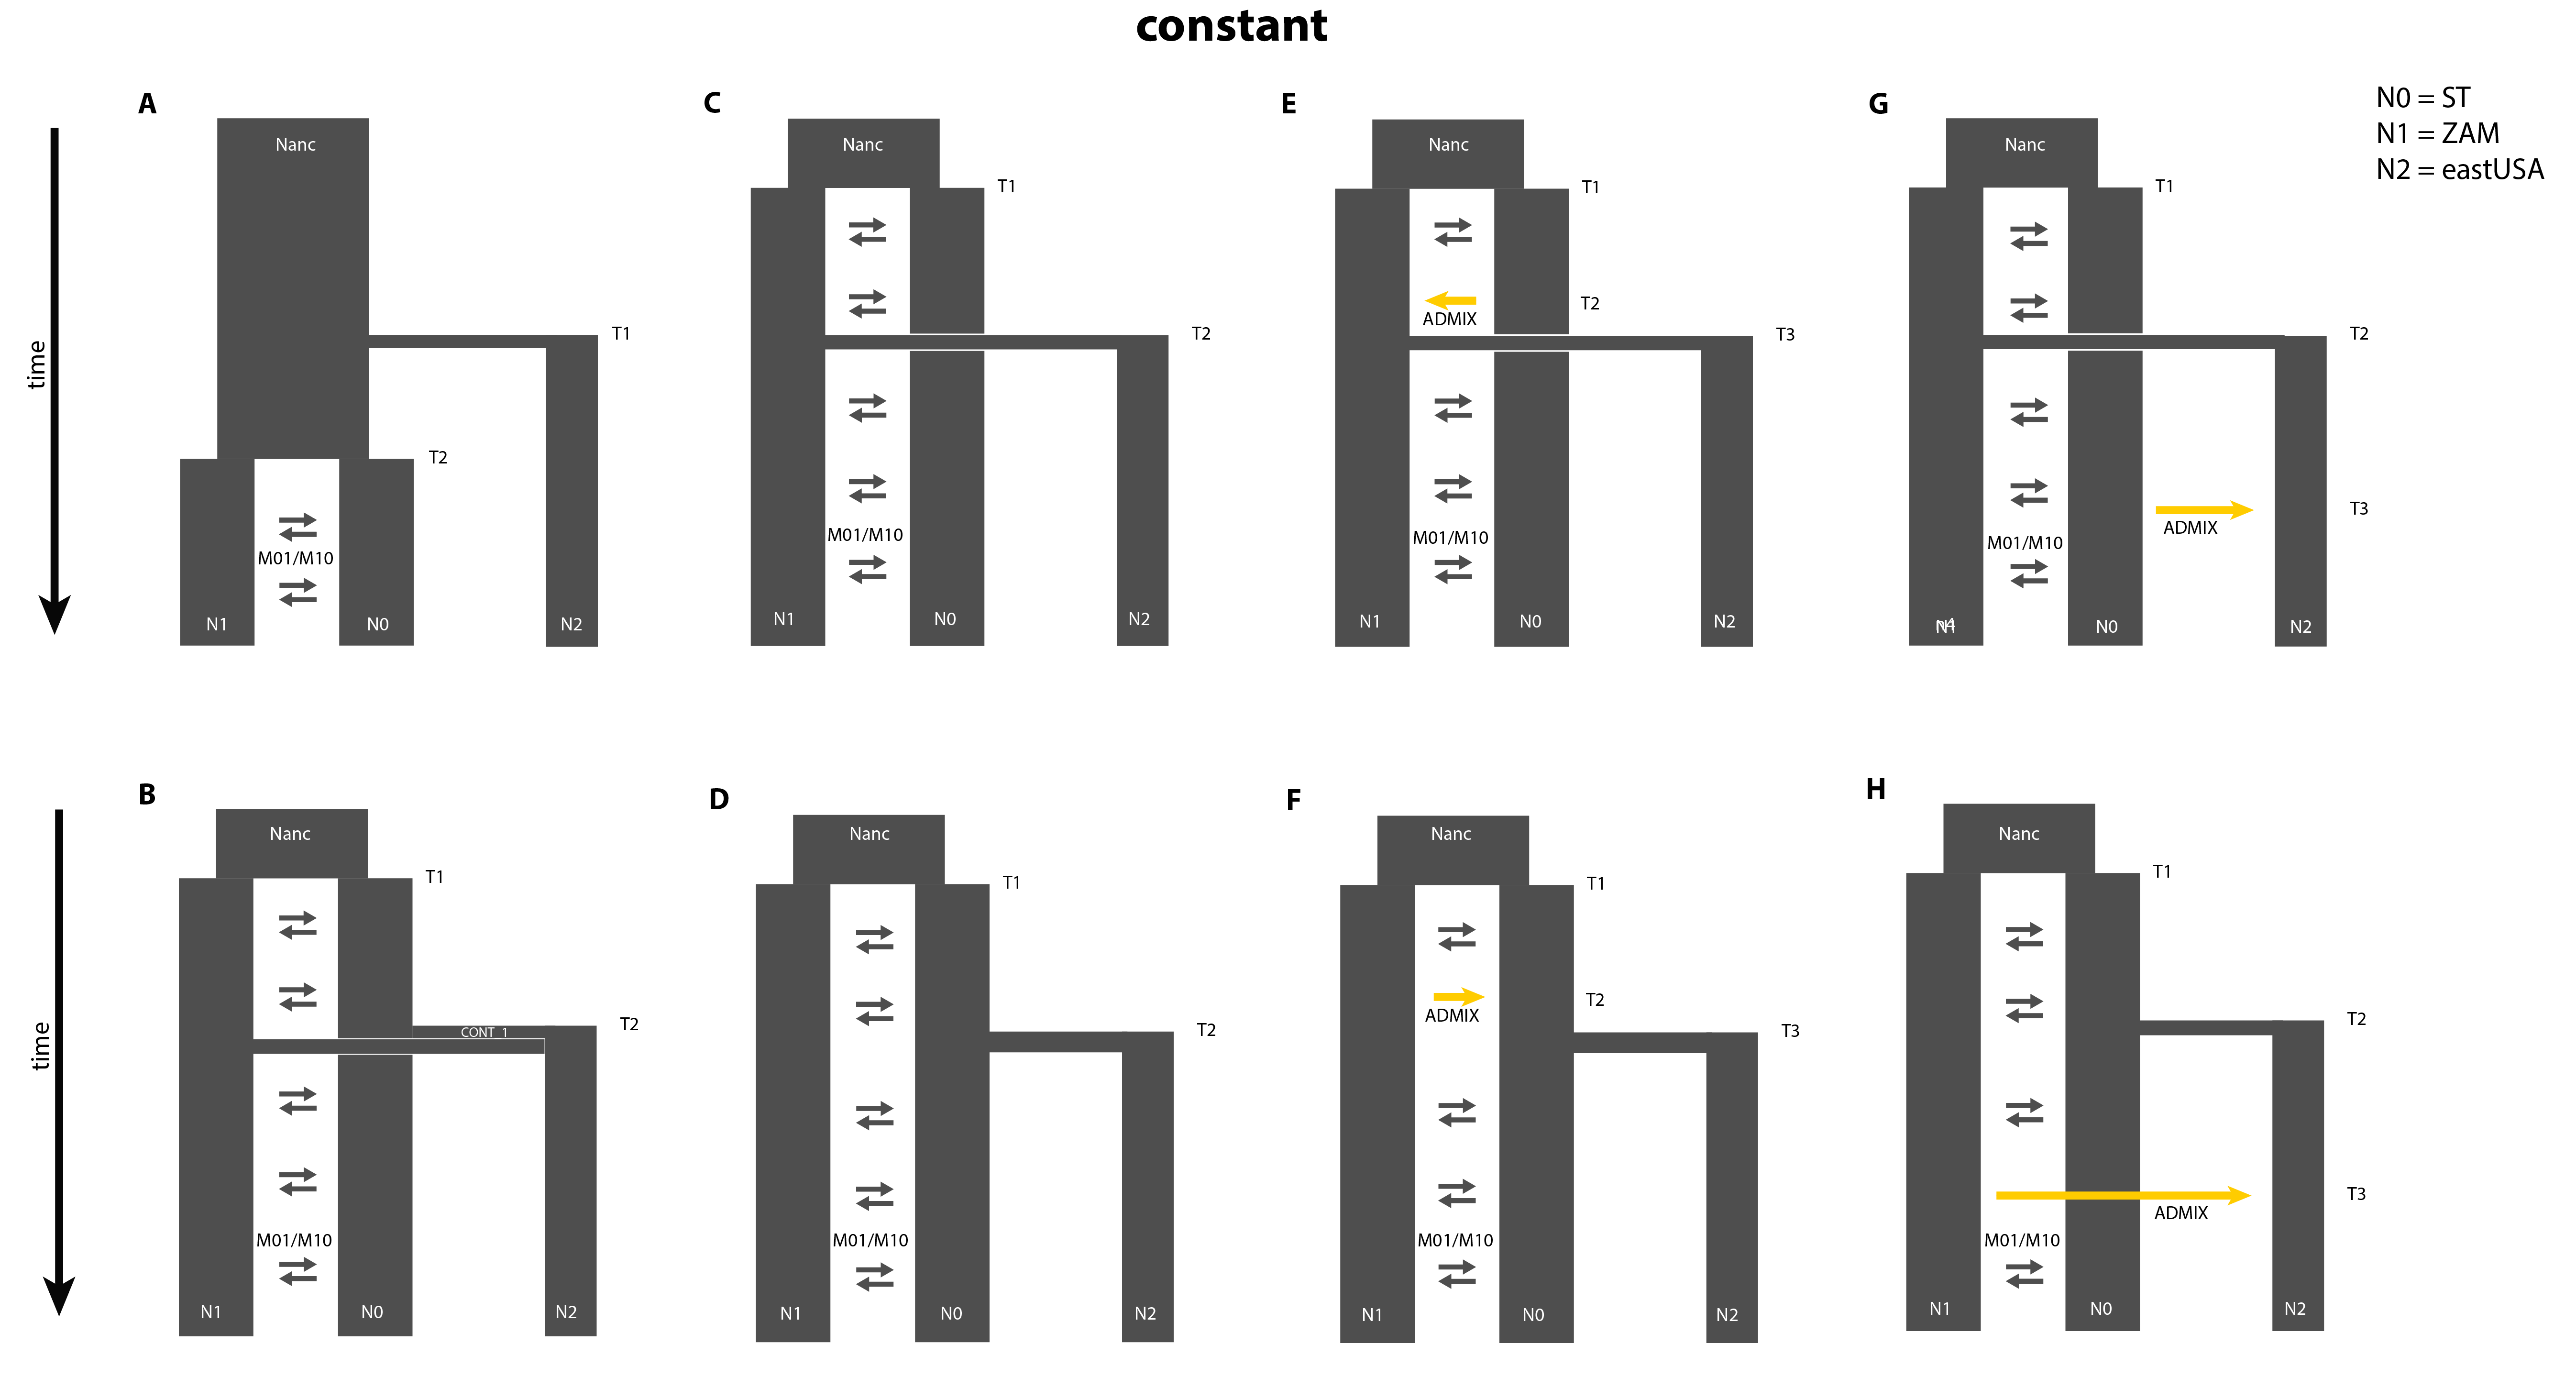

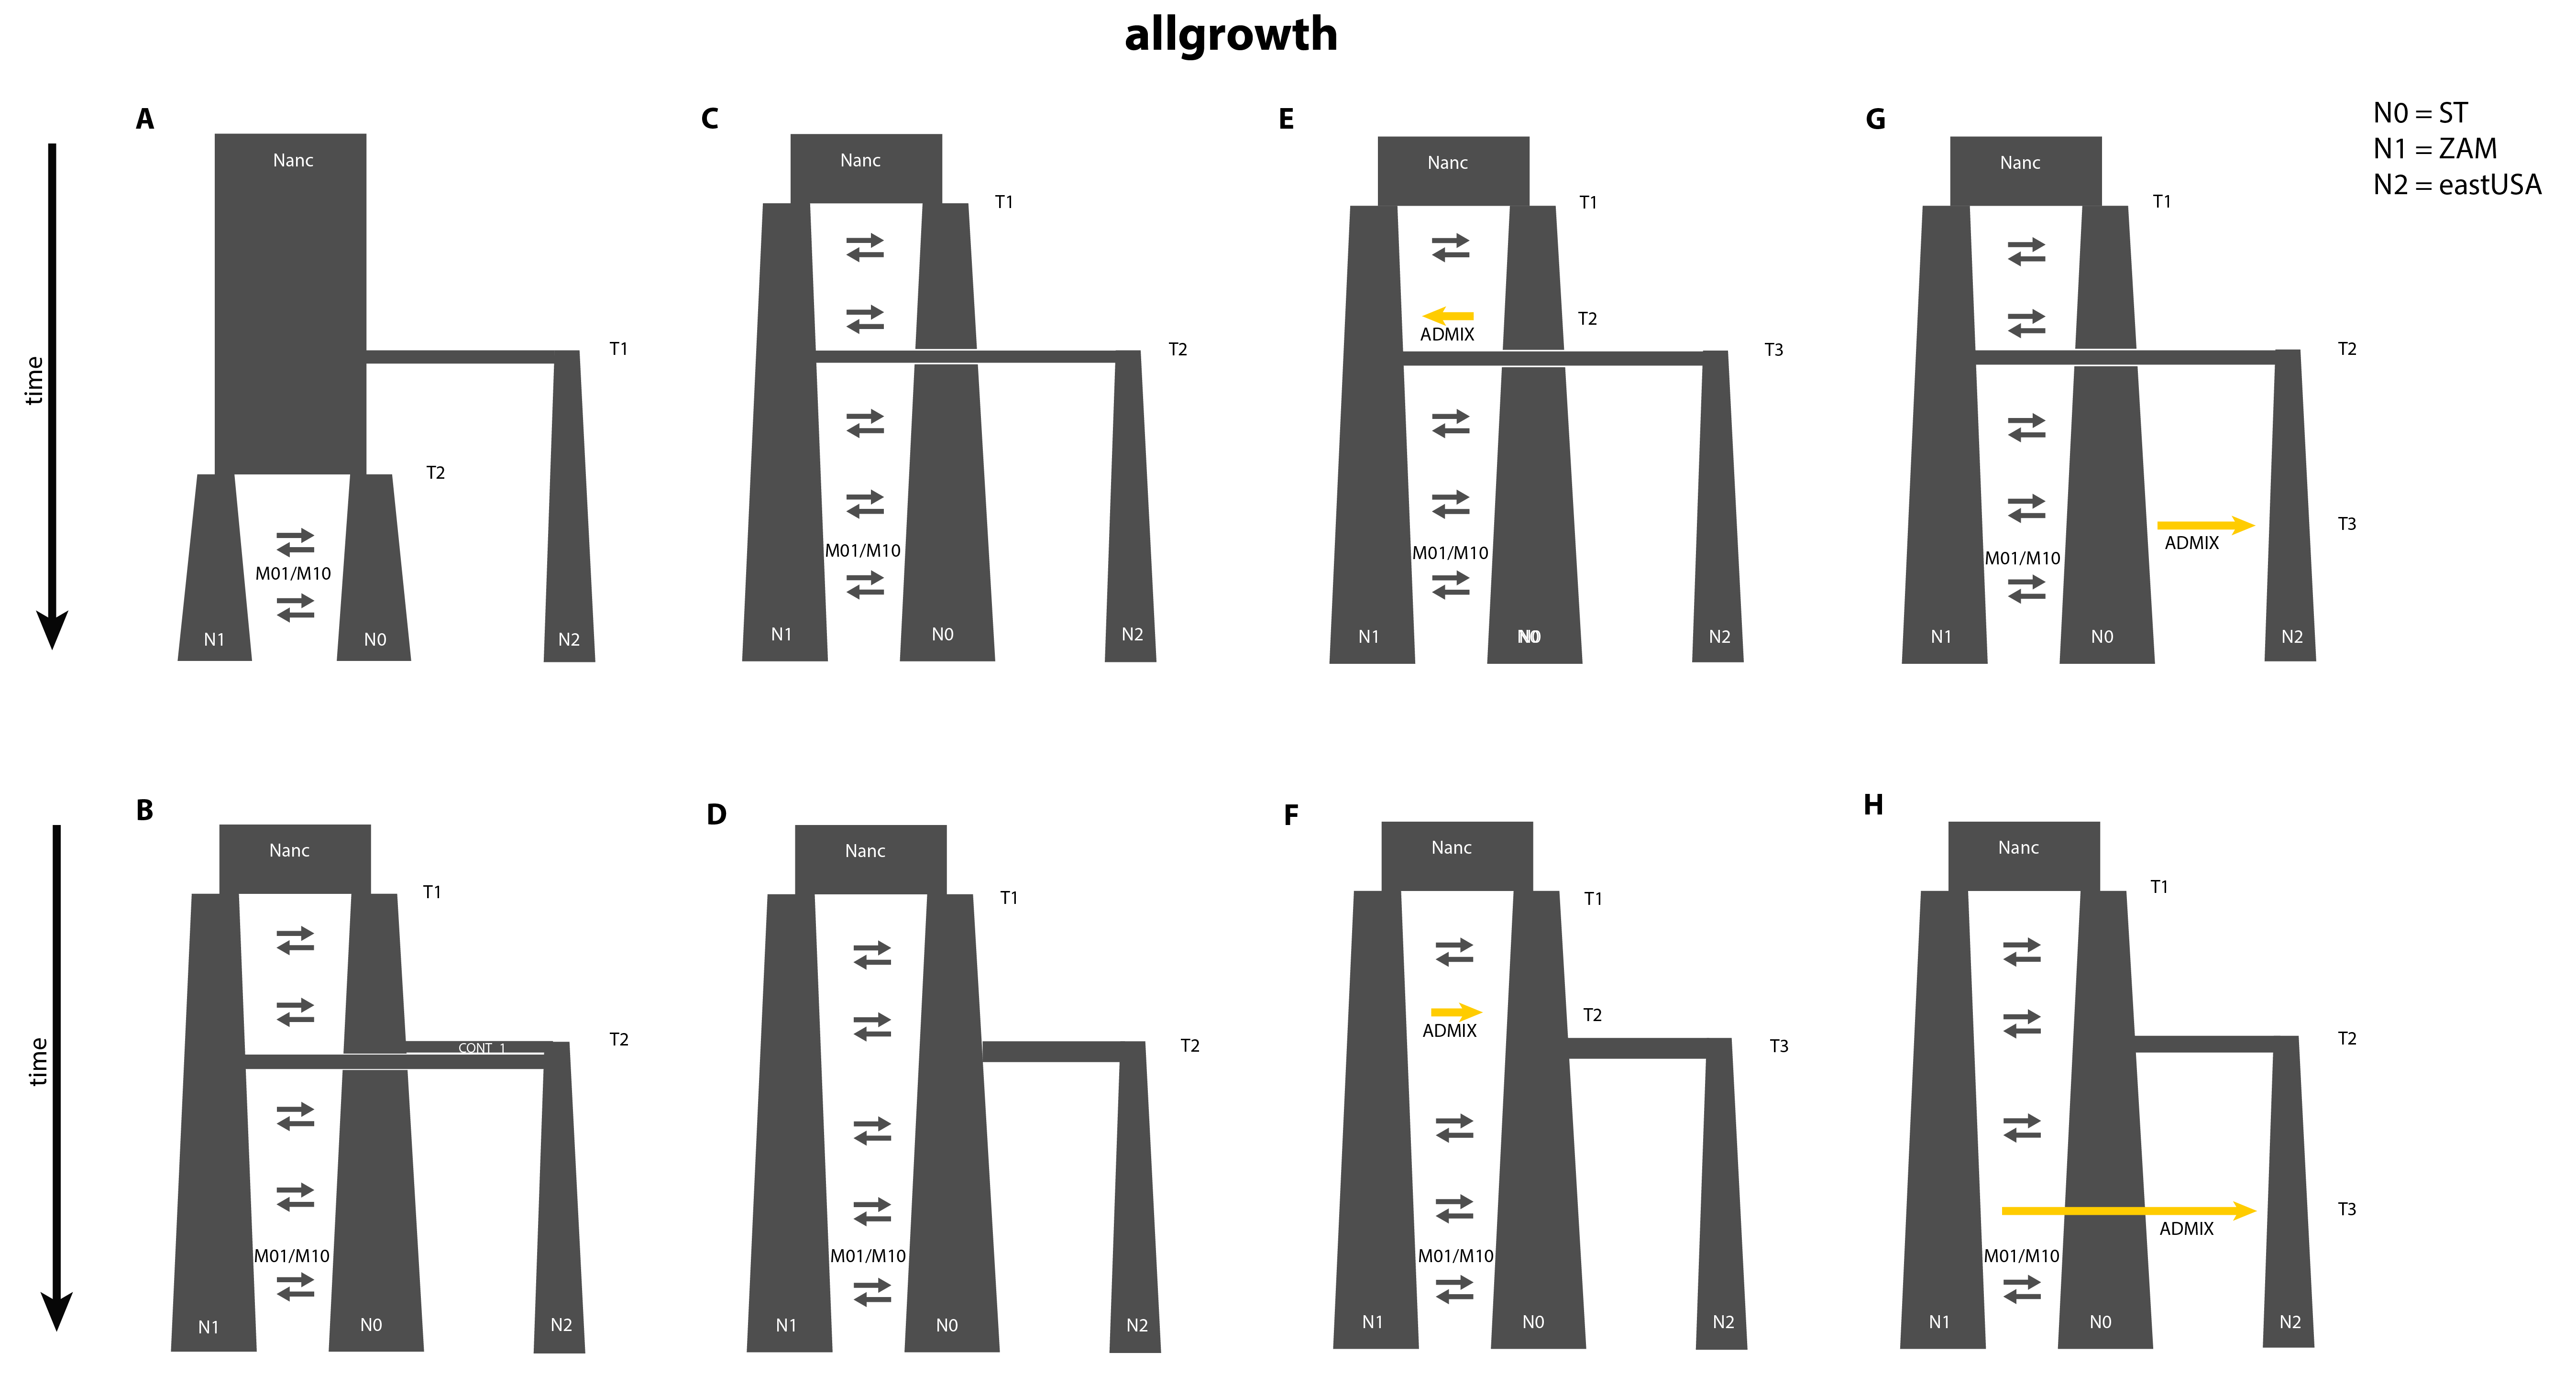

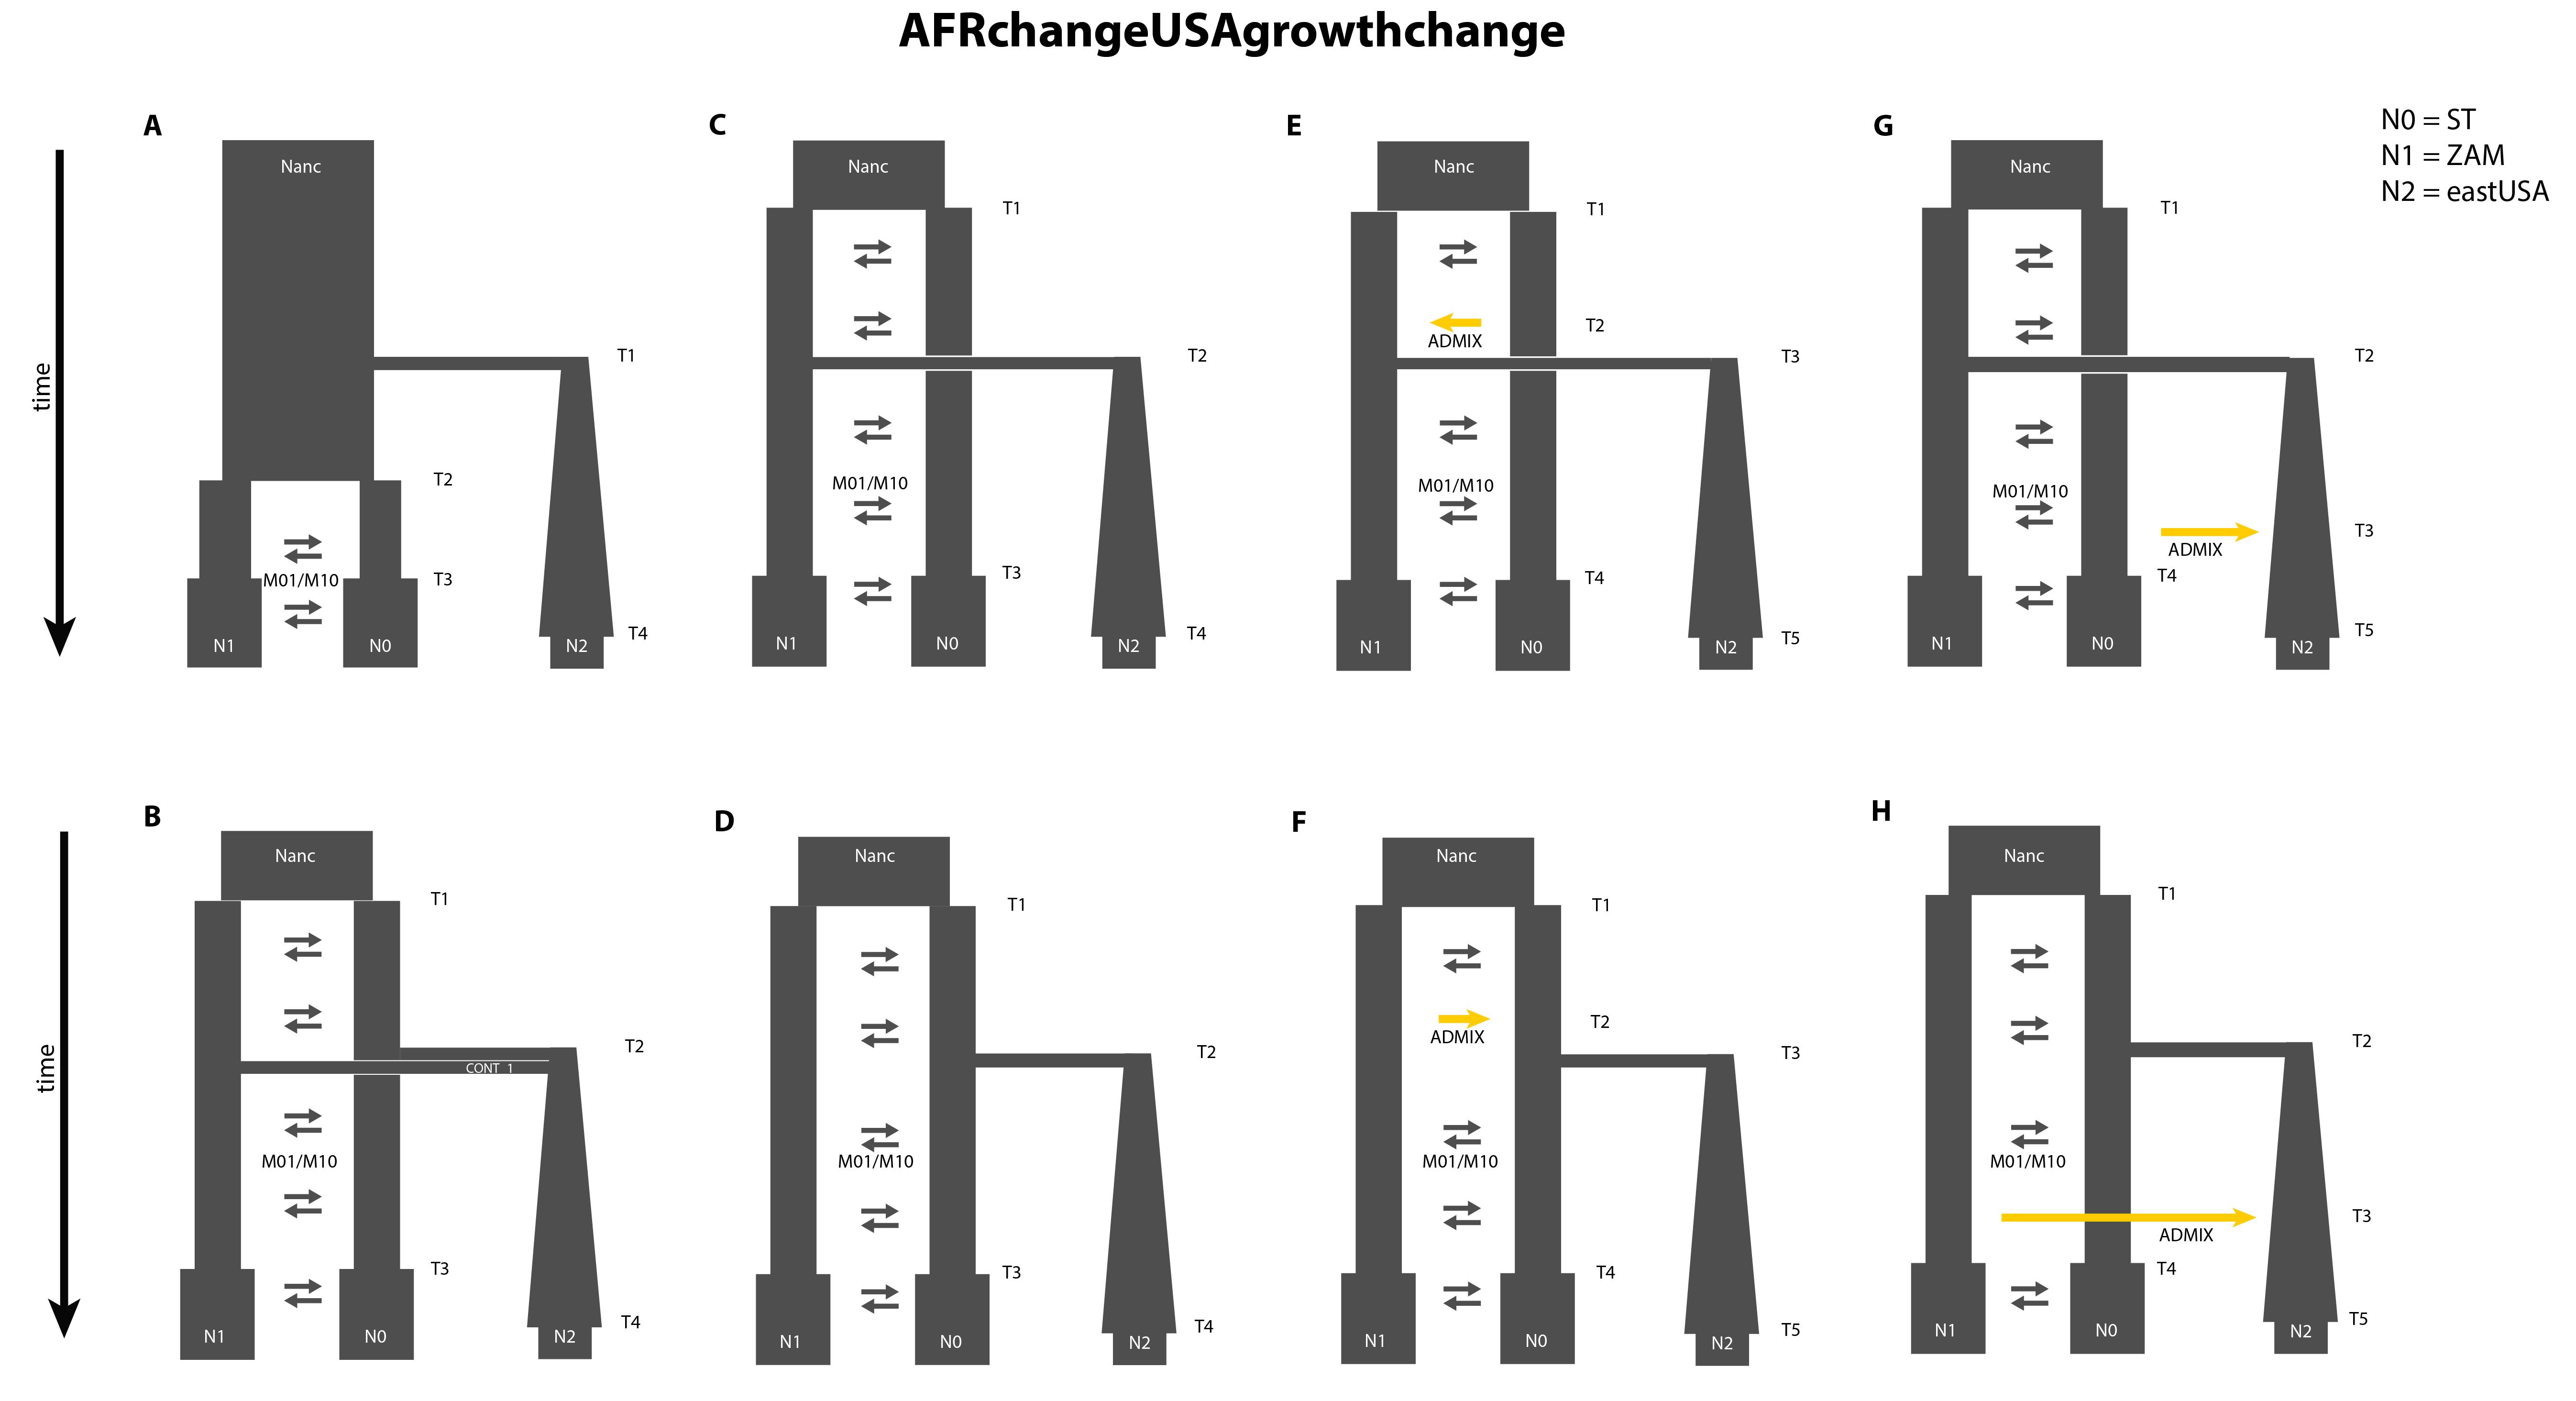

Correspondence of pops and demes in SFS/fsc is:<br>

ST = 0<br>
ZAM = 1<br>
USA = 2<br>

#### scenario A

In [96]:
model = 'A_constant'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''2 historical events\n'''
    '''T2 0 1 1 Nresize_1 0 nomig\n'''
    '''T1 2 1 1 1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''1 T2 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T1 = T2+Tplus1 output\n'''
    '''0 Nresize_1 = Nanc/N1_pres hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and A_constant model


In [69]:
model = 'A_allgrowth'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''R0\n'''
    '''R1\n'''
    '''R2\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''4 historical events\n'''
    '''T2 0 0 0 1 0 nomig\n'''
    '''T2 0 1 1 Nresize_1 0 nomig\n'''
    '''T1 2 2 0 1 0 nomig\n'''
    '''T1 2 1 1 1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''1 T2 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_pres > N2_past\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T1 = T2+Tplus1 output\n'''
    '''0 Nresize_1 = Nanc/N1_past hide\n'''
    '''0 RATIO_0 = N0_past/N0_pres hide\n'''
    '''0 RLOG_0 = log(RATIO_0) hide\n'''
    '''0 R0 = RLOG_0/T2 hide\n'''
    '''0 RATIO_1 = N1_past/N1_pres hide\n'''
    '''0 RLOG_1 = log(RATIO_1) hide\n'''
    '''0 R1 = RLOG_1/T2 hide\n'''
    '''0 RATIO_2 = N2_past/N2_pres hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/T1 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and A_allgrowth model


In [108]:
model = 'A_AFRchange_USAgrowthchange'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''6 historical events\n'''
    '''T4 2 2 0 Nresize_2 R2 keep\n'''
    '''T3 0 0 0 Nresize_0 0 keep\n'''
    '''T3 1 1 0 Nresize_1 0 keep\n'''
    '''T2 0 1 1 Nresize_anc 0 nomig\n'''
    '''T1 2 2 0 1 0 nomig\n'''
    '''T1 2 1 1 1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_fndr logunif 100 1000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-9 1e-4 output\n'''
    '''0 M10 logunif 1e-9 1e-4 output\n'''
    '''1 T4 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 100000 hide\n'''
    '''1 Tplus3 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_past > N2_fndr\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T3 = T4+Tplus1 output\n'''
    '''1 T2 = T3+Tplus2 output\n'''
    '''1 T1 = T2+Tplus3 output\n'''
    '''1 Tgrowth_0 = T1-T4 hide\n'''
    '''0 Nresize_anc = Nanc/N1_past hide\n'''
    '''0 Nresize_0 = N0_past/N0_pres hide\n'''
    '''0 Nresize_1 = N1_past/N1_pres hide\n'''
    '''0 Nresize_2 = N2_past/N2_pres hide\n'''
    '''0 RATIO_2 = N2_fndr/N2_past hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/Tgrowth_0 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and A_AFRchange_USAgrowthchange model


#### scenario B

In [97]:
model = 'B_constant'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''3 historical events\n'''
    '''T2 2 1 CONT_1 1 0 keep\n'''
    '''T2 2 0 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 CONT_1 unif 0.0 0.999 output bounded\n'''
    '''1 T2 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T1 = T2+Tplus1 output\n'''
    '''0 Nresize_1 = Nanc/N1_pres hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and B_constant model


In [65]:
model = 'B_allgrowth'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''R0\n'''
    '''R1\n'''
    '''R2\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''5 historical events\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 1 CONT_1 1 keep keep\n'''
    '''T2 2 0 1 1 keep keep\n'''
    '''T1 0 0 0 1 0 nomig\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 CONT_1 unif 0.0 0.999 output bounded\n'''
    '''1 T2 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_pres > N2_past\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T1 = T2+Tplus1 output\n'''
    '''0 Nresize_1 = Nanc/N1_past hide\n'''
    '''0 RATIO_0 = N0_past/N0_pres hide\n'''
    '''0 RLOG_0 = log(RATIO_0) hide\n'''
    '''0 R0 = RLOG_0/T1 hide\n'''
    '''0 RATIO_1 = N1_past/N1_pres hide\n'''
    '''0 RLOG_1 = log(RATIO_1) hide\n'''
    '''0 R1 = RLOG_1/T1 hide\n'''
    '''0 RATIO_2 = N2_past/N2_pres hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/T2 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and B_allgrowth model


In [35]:
model = 'B_AFRchange_USAgrowthchange'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''7 historical events\n'''
    '''T4 2 2 0 Nresize_2 R2 keep\n'''
    '''T3 0 0 0 Nresize_0 0 keep\n'''
    '''T3 1 1 0 Nresize_1 0 keep\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 1 CONT_1 1 0 keep\n'''
    '''T2 2 0 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_anc 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_fndr logunif 100 1000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-9 1e-4 output\n'''
    '''0 M10 logunif 1e-9 1e-4 output\n'''
    '''0 CONT_1 unif 0.0 0.999 output bounded\n'''
    '''1 T4 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 100000 hide\n'''
    '''1 Tplus3 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_past > N2_fndr\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T3 = T4+Tplus1 output\n'''
    '''1 T2 = T3+Tplus2 output\n'''
    '''1 T1 = T2+Tplus3 output\n'''
    '''1 Tgrowth_0 = T2-T4 hide\n'''
    '''0 Nresize_anc = Nanc/N1_past hide\n'''
    '''0 Nresize_0 = N0_past/N0_pres hide\n'''
    '''0 Nresize_1 = N1_past/N1_pres hide\n'''
    '''0 Nresize_2 = N2_past/N2_pres hide\n'''
    '''0 RATIO_2 = N2_fndr/N2_past hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/Tgrowth_0 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and B_AFRchange_USAgrowthchange model


#### scenario C

In [98]:
model = 'C_constant'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''2 historical events\n'''
    '''T2 2 0 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''1 T2 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T1 = T2+Tplus1 output\n'''
    '''0 Nresize_1 = Nanc/N1_pres hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and C_constant model


In [86]:
model = 'C_allgrowth'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''R0\n'''
    '''R1\n'''
    '''R2\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''4 historical events\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 0 1 1 keep keep\n'''
    '''T1 0 0 0 1 0 nomig\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''1 T2 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_pres > N2_past\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T1 = T2+Tplus1 output\n'''
    '''0 Nresize_1 = Nanc/N1_past hide\n'''
    '''0 RATIO_0 = N0_past/N0_pres hide\n'''
    '''0 RLOG_0 = log(RATIO_0) hide\n'''
    '''0 R0 = RLOG_0/T1 hide\n'''
    '''0 RATIO_1 = N1_past/N1_pres hide\n'''
    '''0 RLOG_1 = log(RATIO_1) hide\n'''
    '''0 R1 = RLOG_1/T1 hide\n'''
    '''0 RATIO_2 = N2_past/N2_pres hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/T2 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and C_allgrowth model


In [37]:
model = 'C_AFRchange_USAgrowthchange'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''6 historical events\n'''
    '''T4 2 2 0 Nresize_2 R2 keep\n'''
    '''T3 0 0 0 Nresize_0 0 keep\n'''
    '''T3 1 1 0 Nresize_1 0 keep\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 0 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_anc 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_fndr logunif 100 1000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-9 1e-4 output\n'''
    '''0 M10 logunif 1e-9 1e-4 output\n'''
    '''1 T4 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 100000 hide\n'''
    '''1 Tplus3 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_past > N2_fndr\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T3 = T4+Tplus1 output\n'''
    '''1 T2 = T3+Tplus2 output\n'''
    '''1 T1 = T2+Tplus3 output\n'''
    '''1 Tgrowth_0 = T2-T4 hide\n'''
    '''0 Nresize_anc = Nanc/N1_past hide\n'''
    '''0 Nresize_0 = N0_past/N0_pres hide\n'''
    '''0 Nresize_1 = N1_past/N1_pres hide\n'''
    '''0 Nresize_2 = N2_past/N2_pres hide\n'''
    '''0 RATIO_2 = N2_fndr/N2_past hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/Tgrowth_0 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and C_AFRchange_USAgrowthchange model


#### scenario D

In [99]:
model = 'D_constant'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''2 historical events\n'''
    '''T2 2 1 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''1 T2 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T1 = T2+Tplus1 output\n'''
    '''0 Nresize_1 = Nanc/N1_pres hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and D_constant model


In [56]:
model = 'D_allgrowth'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''R0\n'''
    '''R1\n'''
    '''R2\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''4 historical events\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 1 1 1 keep keep\n'''
    '''T1 0 0 0 1 0 nomig\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''1 T2 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_pres > N2_past\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T1 = T2+Tplus1 output\n'''
    '''0 Nresize_1 = Nanc/N1_past hide\n'''
    '''0 RATIO_0 = N0_past/N0_pres hide\n'''
    '''0 RLOG_0 = log(RATIO_0) hide\n'''
    '''0 R0 = RLOG_0/T1 hide\n'''
    '''0 RATIO_1 = N1_past/N1_pres hide\n'''
    '''0 RLOG_1 = log(RATIO_1) hide\n'''
    '''0 R1 = RLOG_1/T1 hide\n'''
    '''0 RATIO_2 = N2_past/N2_pres hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/T2 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and D_allgrowth model


In [39]:
model = 'D_AFRchange_USAgrowthchange'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''6 historical events\n'''
    '''T4 2 2 0 Nresize_2 R2 keep\n'''
    '''T3 0 0 0 Nresize_0 0 keep\n'''
    '''T3 1 1 0 Nresize_1 0 keep\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 1 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_anc 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_fndr logunif 100 1000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-9 1e-4 output\n'''
    '''0 M10 logunif 1e-9 1e-4 output\n'''
    '''1 T4 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 100000 hide\n'''
    '''1 Tplus3 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_past > N2_fndr\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T3 = T4+Tplus1 output\n'''
    '''1 T2 = T3+Tplus2 output\n'''
    '''1 T1 = T2+Tplus3 output\n'''
    '''1 Tgrowth_0 = T2-T4 hide\n'''
    '''0 Nresize_anc = Nanc/N1_past hide\n'''
    '''0 Nresize_0 = N0_past/N0_pres hide\n'''
    '''0 Nresize_1 = N1_past/N1_pres hide\n'''
    '''0 Nresize_2 = N2_past/N2_pres hide\n'''
    '''0 RATIO_2 = N2_fndr/N2_past hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/Tgrowth_0 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and D_AFRchange_USAgrowthchange model


#### scenario E

In [101]:
model = 'E_constant'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''3 historical events\n'''
    '''T3 2 0 1 1 0 keep\n'''
    '''T2 0 1 ADMIX 1 0 keep\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T3 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T2 = T3+Tplus1 output\n'''
    '''1 T1 = T2+Tplus2 output\n'''
    '''0 Nresize_1 = Nanc/N1_pres hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and E_constant model


In [57]:
model = 'E_allgrowth'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''R0\n'''
    '''R1\n'''
    '''R2\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''5 historical events\n'''
    '''T3 2 2 0 1 0 keep\n'''
    '''T3 2 0 1 1 keep keep\n'''
    '''T2 0 1 ADMIX 1 keep keep\n'''
    '''T1 0 0 0 1 0 nomig\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T3 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_pres > N2_past\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T2 = T3+Tplus1 output\n'''
    '''1 T1 = T2+Tplus2 output\n'''
    '''0 Nresize_1 = Nanc/N1_past hide\n'''
    '''0 RATIO_0 = N0_past/N0_pres hide\n'''
    '''0 RLOG_0 = log(RATIO_0) hide\n'''
    '''0 R0 = RLOG_0/T1 hide\n'''
    '''0 RATIO_1 = N1_past/N1_pres hide\n'''
    '''0 RLOG_1 = log(RATIO_1) hide\n'''
    '''0 R1 = RLOG_1/T1 hide\n'''
    '''0 RATIO_2 = N2_past/N2_pres hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/T3 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and E_allgrowth model


In [41]:
model = 'E_AFRchange_USAgrowthchange'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''7 historical events\n'''
    '''T5 2 2 0 Nresize_2 R2 keep\n'''
    '''T4 0 0 0 Nresize_0 0 keep\n'''
    '''T4 1 1 0 Nresize_1 0 keep\n'''
    '''T3 2 2 0 1 0 keep\n'''
    '''T3 2 0 1 1 0 keep\n'''
    '''T2 0 1 ADMIX 1 0 keep\n'''
    '''T1 0 1 1 Nresize_anc 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_fndr logunif 100 1000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-9 1e-4 output\n'''
    '''0 M10 logunif 1e-9 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T5 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 100000 hide\n'''
    '''1 Tplus3 unif 100 100000 hide\n'''
    '''1 Tplus4 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_past > N2_fndr\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T4 = T5+Tplus1 output\n'''
    '''1 T3 = T4+Tplus2 output\n'''
    '''1 T2 = T3+Tplus3 output\n'''
    '''1 T1 = T2+Tplus4 output\n'''
    '''1 Tgrowth_0 = T3-T5 hide\n'''
    '''0 Nresize_anc = Nanc/N1_past hide\n'''
    '''0 Nresize_0 = N0_past/N0_pres hide\n'''
    '''0 Nresize_1 = N1_past/N1_pres hide\n'''
    '''0 Nresize_2 = N2_past/N2_pres hide\n'''
    '''0 RATIO_2 = N2_fndr/N2_past hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/Tgrowth_0 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and E_AFRchange_USAgrowthchange model


#### scenario F

In [102]:
model = 'F_constant'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''3 historical events\n'''
    '''T3 2 1 1 1 0 keep\n'''
    '''T2 1 0 ADMIX 1 0 keep\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T3 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T2 = T3+Tplus1 output\n'''
    '''1 T1 = T2+Tplus2 output\n'''
    '''0 Nresize_1 = Nanc/N1_pres hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and F_constant model


In [58]:
model = 'F_allgrowth'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''R0\n'''
    '''R1\n'''
    '''R2\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''5 historical events\n'''
    '''T3 2 2 0 1 0 keep\n'''
    '''T3 2 1 1 1 keep keep\n'''
    '''T2 1 0 ADMIX 1 keep keep\n'''
    '''T1 0 0 0 1 0 nomig\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T3 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_pres > N2_past\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T2 = T3+Tplus1 output\n'''
    '''1 T1 = T2+Tplus2 output\n'''
    '''0 Nresize_1 = Nanc/N1_past hide\n'''
    '''0 RATIO_0 = N0_past/N0_pres hide\n'''
    '''0 RLOG_0 = log(RATIO_0) hide\n'''
    '''0 R0 = RLOG_0/T1 hide\n'''
    '''0 RATIO_1 = N1_past/N1_pres hide\n'''
    '''0 RLOG_1 = log(RATIO_1) hide\n'''
    '''0 R1 = RLOG_1/T1 hide\n'''
    '''0 RATIO_2 = N2_past/N2_pres hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/T3 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and F_allgrowth model


In [43]:
model = 'F_AFRchange_USAgrowthchange'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''7 historical events\n'''
    '''T5 2 2 0 Nresize_2 R2 keep\n'''
    '''T4 0 0 0 Nresize_0 0 keep\n'''
    '''T4 1 1 0 Nresize_1 0 keep\n'''
    '''T3 2 2 0 1 0 keep\n'''
    '''T3 2 1 1 1 0 keep\n'''
    '''T2 1 0 ADMIX 1 0 keep\n'''
    '''T1 0 1 1 Nresize_anc 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_fndr logunif 100 1000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-9 1e-4 output\n'''
    '''0 M10 logunif 1e-9 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T5 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 100000 hide\n'''
    '''1 Tplus3 unif 100 100000 hide\n'''
    '''1 Tplus4 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_past > N2_fndr\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T4 = T5+Tplus1 output\n'''
    '''1 T3 = T4+Tplus2 output\n'''
    '''1 T2 = T3+Tplus3 output\n'''
    '''1 T1 = T2+Tplus4 output\n'''
    '''1 Tgrowth_0 = T3-T5 hide\n'''
    '''0 Nresize_anc = Nanc/N1_past hide\n'''
    '''0 Nresize_0 = N0_past/N0_pres hide\n'''
    '''0 Nresize_1 = N1_past/N1_pres hide\n'''
    '''0 Nresize_2 = N2_past/N2_pres hide\n'''
    '''0 RATIO_2 = N2_fndr/N2_past hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/Tgrowth_0 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and F_AFRchange_USAgrowthchange model


#### scenario G

In [103]:
model = 'G_constant'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''3 historical events\n'''
    '''T3 2 1 ADMIX 1 0 keep\n'''
    '''T2 2 0 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T3 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T2 = T3+Tplus1 output\n'''
    '''1 T1 = T2+Tplus2 output\n'''
    '''0 Nresize_1 = Nanc/N1_pres hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and G_constant model


In [59]:
model = 'G_allgrowth'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''R0\n'''
    '''R1\n'''
    '''R2\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''5 historical events\n'''
    '''T3 2 1 ADMIX 1 keep keep\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 0 1 1 0 keep\n'''
    '''T1 0 0 0 1 0 nomig\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T3 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_pres > N2_past\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T2 = T3+Tplus1 output\n'''
    '''1 T1 = T2+Tplus2 output\n'''
    '''0 Nresize_1 = Nanc/N1_past hide\n'''
    '''0 RATIO_0 = N0_past/N0_pres hide\n'''
    '''0 RLOG_0 = log(RATIO_0) hide\n'''
    '''0 R0 = RLOG_0/T1 hide\n'''
    '''0 RATIO_1 = N1_past/N1_pres hide\n'''
    '''0 RLOG_1 = log(RATIO_1) hide\n'''
    '''0 R1 = RLOG_1/T1 hide\n'''
    '''0 RATIO_2 = N2_past/N2_pres hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/T2 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and G_allgrowth model


In [45]:
model = 'G_AFRchange_USAgrowthchange'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''7 historical events\n'''
    '''T5 2 2 0 Nresize_2 R2 keep\n'''
    '''T4 0 0 0 Nresize_0 0 keep\n'''
    '''T4 1 1 0 Nresize_1 0 keep\n'''
    '''T3 2 1 ADMIX 1 0 keep\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 0 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_anc 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_fndr logunif 100 1000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-9 1e-4 output\n'''
    '''0 M10 logunif 1e-9 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T5 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 100000 hide\n'''
    '''1 Tplus3 unif 100 100000 hide\n'''
    '''1 Tplus4 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_past > N2_fndr\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T4 = T5+Tplus1 output\n'''
    '''1 T3 = T4+Tplus2 output\n'''
    '''1 T2 = T3+Tplus3 output\n'''
    '''1 T1 = T2+Tplus4 output\n'''
    '''1 Tgrowth_0 = T2-T5 hide\n'''
    '''0 Nresize_anc = Nanc/N1_past hide\n'''
    '''0 Nresize_0 = N0_past/N0_pres hide\n'''
    '''0 Nresize_1 = N1_past/N1_pres hide\n'''
    '''0 Nresize_2 = N2_past/N2_pres hide\n'''
    '''0 RATIO_2 = N2_fndr/N2_past hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/Tgrowth_0 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and G_AFRchange_USAgrowthchange model


#### scenario H

In [104]:
model = 'H_constant'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''3 historical events\n'''
    '''T3 2 0 ADMIX 1 0 keep\n'''
    '''T2 2 1 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T3 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T2 = T3+Tplus1 output\n'''
    '''1 T1 = T2+Tplus2 output\n'''
    '''0 Nresize_1 = Nanc/N1_pres hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and H_constant model


In [60]:
model = 'H_allgrowth'

if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''R0\n'''
    '''R1\n'''
    '''R2\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''5 historical events\n'''
    '''T3 2 0 ADMIX 1 keep keep\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 1 1 1 0 keep\n'''
    '''T1 0 0 0 1 0 nomig\n'''
    '''T1 0 1 1 Nresize_1 0 nomig\n'''
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-10 1e-4 output\n'''
    '''0 M10 logunif 1e-10 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T3 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_pres > N2_past\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T2 = T3+Tplus1 output\n'''
    '''1 T1 = T2+Tplus2 output\n'''
    '''0 Nresize_1 = Nanc/N1_past hide\n'''
    '''0 RATIO_0 = N0_past/N0_pres hide\n'''
    '''0 RLOG_0 = log(RATIO_0) hide\n'''
    '''0 R0 = RLOG_0/T1 hide\n'''
    '''0 RATIO_1 = N1_past/N1_pres hide\n'''
    '''0 RLOG_1 = log(RATIO_1) hide\n'''
    '''0 R1 = RLOG_1/T1 hide\n'''
    '''0 RATIO_2 = N2_past/N2_pres hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/T2 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and H_allgrowth model


In [47]:
model = 'H_AFRchange_USAgrowthchange'
if not os.path.exists('{}/{}/{}'.format(fsc_dir,pops,model)):
    os.mkdir('{}/{}/{}'.format(fsc_dir,pops,model))

tpl = (
    '''//Number of population samples (demes)\n'''
    '''3\n'''
    '''//Population effective sizes (number of genes)\n'''
    '''N0_pres\n'''
    '''N1_pres\n'''
    '''N2_pres\n'''
    '''//Samples sizes\n'''
    '''{num_alleles_pop1}\n'''
    '''{num_alleles_pop2}\n'''
    '''{num_alleles_pop3}\n'''
    '''//Growth rates : negative growth implies population expansion\n'''
    '''0\n'''
    '''0\n'''
    '''0\n'''
    '''//Number of migration matrices : 0 implies no migration between demes\n'''
    '''1\n'''
    '''//Migration matrix 0\n'''
    '''0 M01 0\n'''
    '''M10 0 0\n'''
    '''0 0 0\n'''
    '''//Historical event : time, source, sink, migrants, new deme size, new growth rate, migration matrix index\n'''
    '''7 historical events\n'''
    '''T5 2 2 0 Nresize_2 R2 keep\n'''
    '''T4 0 0 0 Nresize_0 0 keep\n'''
    '''T4 1 1 0 Nresize_1 0 keep\n'''
    '''T3 2 0 ADMIX 1 0 keep\n'''
    '''T2 2 2 0 1 0 keep\n'''
    '''T2 2 1 1 1 0 keep\n'''
    '''T1 0 1 1 Nresize_anc 0 nomig\n''' 
    '''//Number of independent loci [chromosome]\n'''
    '''1 0\n'''
    '''//Per chromosome: Number of contiguous linkage Block: a block is a set of contiguous loci\n'''
    '''1\n'''
    '''//per Block : data type, number of loci, per generation recombination and mutation rates and optional parameters\n'''
    '''FREQ 1 0 2.8e-9 OUTEXP\n''').format(pop1=pop1,pop2=pop2,pop3=pop3,
        num_alleles_pop1=pop_size[pop1],num_alleles_pop2=pop_size[pop2],num_alleles_pop3=pop_size[pop3])

est = (
    '''// Priors and rules file\n'''
    '''// *********************\n\n'''
    '''[PARAMETERS]\n'''
    '''//#isInt? #name #dist #min #max\n'''
    '''//all Ns are in number of haploid individuals\n'''
    '''1 Nanc logunif 1000 10000000 output\n'''
    '''1 N0_past logunif 1000 10000000 output\n'''
    '''1 N0_pres logunif 1000 10000000 output\n'''
    '''1 N1_past logunif 1000 10000000 output\n'''
    '''1 N1_pres logunif 1000 10000000 output\n'''
    '''1 N2_fndr logunif 100 1000000 output\n'''
    '''1 N2_past logunif 100 1000000 output\n''' 
    '''1 N2_pres logunif 100 1000000 output\n''' 
    '''0 M01 logunif 1e-9 1e-4 output\n'''
    '''0 M10 logunif 1e-9 1e-4 output\n'''
    '''0 ADMIX unif 0.25 0.999 output bounded\n'''
    '''1 T5 unif 100 100000 output\n'''
    '''1 Tplus1 unif 100 100000 hide\n'''
    '''1 Tplus2 unif 100 100000 hide\n'''
    '''1 Tplus3 unif 100 100000 hide\n'''
    '''1 Tplus4 unif 100 1000000 hide\n'''
    '''\n'''
    '''[RULES]\n'''
    '''N0_pres > N0_past\n'''
    '''N1_pres > N1_past\n'''
    '''N2_past > N2_fndr\n'''
    '''\n'''
    '''[COMPLEX PARAMETERS]\n'''
    '''1 T4 = T5+Tplus1 output\n'''
    '''1 T3 = T4+Tplus2 output\n'''
    '''1 T2 = T3+Tplus3 output\n'''
    '''1 T1 = T2+Tplus4 output\n'''
    '''1 Tgrowth_0 = T2-T5 hide\n'''
    '''0 Nresize_anc = Nanc/N1_past hide\n'''
    '''0 Nresize_0 = N0_past/N0_pres hide\n'''
    '''0 Nresize_1 = N1_past/N1_pres hide\n'''
    '''0 Nresize_2 = N2_past/N2_pres hide\n'''
    '''0 RATIO_2 = N2_fndr/N2_past hide\n'''
    '''0 RLOG_2 = log(RATIO_2) hide\n'''
    '''0 R2 = RLOG_2/Tgrowth_0 hide\n''').format(pop1=pop1,pop2=pop2,pop3=pop3)

tpl_file = '{}/{}/{}/{}.tpl'.format(fsc_dir,pops,model,pops,pops)
est_file = '{}/{}/{}/{}.est'.format(fsc_dir,pops,model,pops,pops)

with open(tpl_file, 'w') as out_tpl, open(est_file, 'w') as out_est:
    out_tpl.write(tpl)
    out_est.write(est)
    print('tpl and est files written for {} and {} model'.format(pops, model))

tpl and est files written for st_zam_usa and H_AFRchange_USAgrowthchange model


### Create and submit slurm array script

This will use the function defined at top to create a slurm submission script to run fastsimcoal. Multiple runs will be submitted in form of one array

In [ ]:
threepop_models = [ abc.upper() + '_allgrowth' for abc in list(map(chr, range(97, 105))) ]

for model in threepop_models:

    sfs_dir = os.path.join(fsc_dir,pops)
    work_dir = os.path.join(fsc_dir,pops,model)
    
    fsc = ('''\n'''
        '''run_dir="{work_dir}/run_${{SLURM_ARRAY_TASK_ID}}"\n\n'''
        '''if [ ! -f ${{run_dir}}/{pops}/{pops}.bestlhoods ]; then \n\n'''
        '''\tmkdir -p ${{run_dir}}\n\n'''
        '''\tcp {work_dir}/{pops}.tpl {work_dir}/{pops}.est {sfs_dir}/{pops}_DSFS.obs ${{run_dir}}\n\n'''
        '''\tcd ${{run_dir}}\n\n'''
        '''\tfsc26 -t {pops}.tpl -e {pops}.est --multiSFS --cores 2 --numBatches 2 -C 1 '''
        '''--maxlhood --quiet --dsfs --numloops 100 --numsims 200000 --logprecision 18 --brentol 0.0001 \n\n'''
        '''\tcd {work_dir}; fi\n''').format(work_dir=work_dir,sfs_dir=sfs_dir,pops=pops)
    
    slurm = make_slurm(jobName='fsc_{}_{}'.format(pops,model),cmd_string=fsc,run=True,echo=False,
                       mem='250mb',c=2,time='2-00:00',array='1-100%100')

In [92]:
# check on status ob jobs
sacct_extract('fsc')

### Summarize model output

Extract results and store everything in a bunch of pandas DFs

In [9]:
pd.options.mode.chained_assignment = None

# set up empty lists and dataframes, etc.
threepop_models_allgrowth = [ abc.upper() + '_allgrowth' for abc in list(map(chr, range(97, 105))) ]
threepop_models_AFRchange_USAgrowthchange = [ abc.upper() + '_AFRchange_USAgrowthchange' for abc in list(map(chr, range(97, 105))) ]
threepop_models_constant = [ abc.upper() + '_constant' for abc in list(map(chr, range(97, 105))) ]
variations = [threepop_models_allgrowth, threepop_models_AFRchange_USAgrowthchange, threepop_models_constant]
threepop_models = list(itertools.chain.from_iterable(variations))

threepop_models_results  = {}
threepop_models_topmaxL = {}
threepop_models_llhoods = {}
threepop_models_AIC = {}
threepop_models_bestrun = {}
threepop_models_params_no = {}

# now populate pandas dataframes
for model in threepop_models:
    
    # get one pv file to automatically extract number of parameters in model and save in dict
    pv_file = glob.glob(os.path.join(fsc_dir,pops,model) + '/run*/**/*.pv', recursive=True)[0]
    threepop_models_params_no[model] = np.loadtxt(pv_file,skiprows=1).size

    # get all best lhood fsc output files
    bestlhoods_files = glob.glob(os.path.join(fsc_dir,pops,model) + '/run_*/**/*.bestlhoods', recursive=True)
    
    # optional - extract certain range of runs and get failed run numbers
    target_runs = [ 'run_' + str(i) for i in range(1,101) ]
    bestlhoods_files = [ file for file in bestlhoods_files if any(run + '/' in file for run in target_runs) ]
    failed_runs = [ run for run in target_runs if not any(run + '/' in file for file in bestlhoods_files) ]
    
    print("number of successfull runs for model", model, ": ", len(bestlhoods_files))
    print("failed runs for model", model, ": ", *failed_runs)
    
    if bestlhoods_files:
        threepop_models_results[model] = pd.concat((pd.read_csv(file, sep="\t").assign(Run=file.split('/')[-3]) 
                                         for file in bestlhoods_files), ignore_index=True)
        
        threepop_models_results[model]['MaxEstNatLhood'] = threepop_models_results[model]['MaxEstLhood'] * np.log(2)/np.log10(2)
        threepop_models_results[model]['Params_no'] = threepop_models_params_no[model]
        threepop_models_results[model]['AIC'] = 2 * threepop_models_params_no[model] - 2 * threepop_models_results[model]['MaxEstNatLhood']
        
        threepop_models_topmaxL[model] = threepop_models_results[model].sort_values('MaxEstLhood', ascending=False)[:3]
        
        threepop_models_bestrun[model] = threepop_models_topmaxL[model][['Run']][0:1].values[0]
        
        threepop_models_llhoods[model] = threepop_models_topmaxL[model][['Run','MaxEstLhood','MaxEstNatLhood','Params_no','AIC']]

threepop_models_AIC = pd.concat(threepop_models_llhoods.values(), keys=threepop_models_llhoods.keys(), axis=0
             ).sort_values(by=['AIC'],ascending=True)

#### Repeat failed runs

Check if any runs failed for whatever reason and if so, re-submit based on fsc run number (not jobID)

In [12]:
failed_runs

[]

In [ ]:
# just set model name and run number (works based on array task id)

model = "H_allgrowth"
run = 91     

sfs_dir = os.path.join(fsc_dir,pops)
work_dir = os.path.join(fsc_dir,pops,model)

fsc = ('''\n'''
    '''run_dir="{work_dir}/run_${{SLURM_ARRAY_TASK_ID}}"\n\n'''
    '''if [ ! -f ${{run_dir}}/{pops}/{pops}.bestlhoods ]; then \n\n'''
    '''\tmkdir -p ${{run_dir}}\n\n'''
    '''\tcp {work_dir}/{pops}.tpl {work_dir}/{pops}.est {sfs_dir}/{pops}_DSFS.obs ${{run_dir}}\n\n'''
    '''\tcd ${{run_dir}}\n\n'''
    '''\tfsc26 -t {pops}.tpl -e {pops}.est --multiSFS --cores 8 --numBatches 8 -C 1 '''
    '''--maxlhood --quiet --dsfs --numloops 100 --numsims 200000 --logprecision 18 --brentol 0.0001 \n\n'''
    '''\tcd {work_dir}; fi\n''').format(work_dir=work_dir,sfs_dir=sfs_dir,pops=pops)

slurm = make_slurm(jobName='fsc_{}_{}_{}'.format(pops,model,run),cmd_string=fsc,run=True,echo=False,
                   mem='250mb',c=8,time='2-00:00',array='{}-{}%1'.format(run,run))

In [93]:
# check again on status
sacct_extract("fsc")

#### AIC

Create table of Akaike Information Criterion scores. AIC is based on ln (natural log) and not log10 (converted before; see code above). Table is sorted by AIC (models on top provide better fit)

In [14]:
pd.options.display.max_rows = 100

threepop_models_AIC

Run   MaxEstLhood  MaxEstNatLhood  \
F_allgrowth                 98   run_92 -3.207749e+07   -7.386114e+07   
G_allgrowth                 89   run_73 -3.207914e+07   -7.386495e+07   
                            51   run_13 -3.207976e+07   -7.386639e+07   
                            10    run_8 -3.207990e+07   -7.386670e+07   
F_allgrowth                 29   run_60 -3.208029e+07   -7.386759e+07   
                            5    run_14 -3.208115e+07   -7.386957e+07   
B_allgrowth                 62    run_7 -3.208579e+07   -7.388026e+07   
                            17   run_85 -3.208600e+07   -7.388076e+07   
                            97   run_35 -3.208624e+07   -7.388129e+07   
D_allgrowth                 75   run_17 -3.209977e+07   -7.391246e+07   
                            69   run_57 -3.210086e+07   -7.391495e+07   
                            47   run_44 -3.210112e+07   -7.391555e+07   
F_AFRchange_USAgrowthchange 93    run_2 -3.210312e+07   -7.392017e+07   
                            44   run_41 -3.210322e+07   -7.392040e+07   
                            21   run_31 -3.210332e+07   -7.392062e+07   
E_allgrowth                 56   run_16 -3.210580e+07   -7.392633e+07   
                            84   run_78 -3.211015e+07   -7.393636e+07   
                            71   run_79 -3.211040e+07   -7.393693e+07   
F_constant                  2    run_59 -3.211209e+07   -7.394082e+07   
                            92   run_69 -3.211230e+07   -7.394129e+07   
                            14   run_61 -3.211313e+07   -7.394321e+07   
H_allgrowth                 7    run_26 -3.211366e+07   -7.394443e+07   
                            25   run_75 -3.211733e+07   -7.395289e+07   
                            20   run_91 -3.211805e+07   -7.395454e+07   
C_allgrowth                 48   run_58 -3.213277e+07   -7.398844e+07   
                            1    run_66 -3.213294e+07   -7.398882e+07   
                            96   run_89 -3.213323e+07   -7.398949e+07   
E_AFRchange_USAgrowthchange 80  run_100 -3.218754e+07   -7.411454e+07   
                            84   run_78 -3.220469e+07   -7.415404e+07   
B_AFRchange_USAgrowthchange 11   run_38 -3.221234e+07   -7.417166e+07   
                            48   run_58 -3.221508e+07   -7.417795e+07   
G_AFRchange_USAgrowthchange 4    run_95 -3.221671e+07   -7.418171e+07   
B_AFRchange_USAgrowthchange 27   run_22 -3.221708e+07   -7.418256e+07   
G_AFRchange_USAgrowthchange 58   run_46 -3.221725e+07   -7.418296e+07   
                            64   run_80 -3.221745e+07   -7.418342e+07   
E_AFRchange_USAgrowthchange 64   run_80 -3.222155e+07   -7.419286e+07   
H_AFRchange_USAgrowthchange 16   run_30 -3.222238e+07   -7.419477e+07   
                            8    run_99 -3.222349e+07   -7.419733e+07   
                            98   run_92 -3.222390e+07   -7.419828e+07   
C_AFRchange_USAgrowthchange 84   run_78 -3.229441e+07   -7.436062e+07   
                            45   run_76 -3.229946e+07   -7.437226e+07   
                            32   run_98 -3.230054e+07   -7.437475e+07   
D_AFRchange_USAgrowthchange 39   run_45 -3.232507e+07   -7.443122e+07   
                            92   run_69 -3.232515e+07   -7.443141e+07   
                            43   run_49 -3.236822e+07   -7.453058e+07   
H_constant                  67   run_82 -3.247023e+07   -7.476547e+07   
                            6    run_42 -3.247271e+07   -7.477119e+07   
                            98   run_92 -3.247284e+07   -7.477147e+07   
G_constant                  68   run_96 -3.247289e+07   -7.477160e+07   
                            47   run_44 -3.247306e+07   -7.477199e+07   
                            97   run_35 -3.247414e+07   -7.477447e+07   
B_constant                  15   run_11 -3.247503e+07   -7.477651e+07   
                            96   run_89 -3.247507e+07   -7.477662e+07   
                            62    run_7 -3.247545e+07   -7.477749e+07   
D_constant           

#### Show top three runs for each model

There's often quite a bit of variance in likelihoods and parameter estimates for the same model (even with many MCMC iterations), so it's often helpful to have a look at the top n runs for each model

In [15]:
pd.options.display.max_columns = None

for model in threepop_models:
    display(model,threepop_models_topmaxL[model])

'A_allgrowth'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_past,N2_pres,M01,M10,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
21,4770947,20827846,29484634,8182117,23954584,1841821,1887111,2.542760e-09,3.956780e-10,552177,555898,-3.268930e+07,-3.189740e+07,run_31,-7.526990e+07,11,1.505398e+08
84,4715309,20208887,25599681,14504828,20628471,1842629,1855970,6.239870e-09,8.501430e-09,536919,541282,-3.269158e+07,-3.189740e+07,run_78,-7.527514e+07,11,1.505503e+08
80,4616985,13536653,32870106,13693461,17614582,1726233,1792674,7.160130e-09,5.552940e-08,539254,542354,-3.269250e+07,-3.189740e+07,run_100,-7.527725e+07,11,1.505545e+08


'B_allgrowth'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_past,N2_pres,M01,M10,CONT_1,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
62,11938524,9471502,16275863,84266,20140752,311,169500,0.000001,3.567830e-07,0.681595,616,3682445,-3.208579e+07,-3.189740e+07,run_7,-7.388026e+07,12,1.477605e+08
17,10676144,11589749,14498145,97300,19219092,259976,445474,0.000001,3.437400e-07,0.664474,85876,3518094,-3.208600e+07,-3.189740e+07,run_85,-7.388076e+07,12,1.477615e+08
97,8480381,15815298,16669363,56348,18412220,26784,1002149,0.000001,5.277840e-07,0.646181,31085,3409746,-3.208624e+07,-3.189740e+07,run_35,-7.388129e+07,12,1.477626e+08


'C_allgrowth'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_past,N2_pres,M01,M10,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
48,10501046,13892858,19360839,88676,17633490,37725,465108,0.000001,4.912130e-07,28335,3322846,-3.213277e+07,-3.189740e+07,run_58,-7.398844e+07,11,1.479769e+08
1,9242544,14254186,19520270,34045,16295796,54896,396317,0.000001,7.255870e-07,33374,3255589,-3.213294e+07,-3.189740e+07,run_66,-7.398882e+07,11,1.479777e+08
96,10526381,18765655,21095104,109495,19056681,322,189447,0.000001,3.800670e-07,689,3397876,-3.213323e+07,-3.189740e+07,run_89,-7.398949e+07,11,1.479790e+08


'D_allgrowth'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_past,N2_pres,M01,M10,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
75,11837424,14498782,20501597,12092,18171428,724,397316,0.000001,6.860010e-07,1419,3963020,-3.209977e+07,-3.189740e+07,run_17,-7.391246e+07,11,1.478249e+08
69,11859078,11417834,16152543,11708,18449885,187337,512921,0.000001,6.954380e-07,72012,3839758,-3.210086e+07,-3.189740e+07,run_57,-7.391495e+07,11,1.478299e+08
47,12776854,14818986,16980437,20207,20255131,699,344127,0.000001,6.010090e-07,1318,3757744,-3.210112e+07,-3.189740e+07,run_44,-7.391555e+07,11,1.478311e+08


'E_allgrowth'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_past,N2_pres,M01,M10,ADMIX,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
56,9403516,15154952,18076251,144479,27605049,337838,404889,2.011760e-08,2.033950e-08,0.987057,95711,202935,4094864,-3.210580e+07,-3.189740e+07,run_16,-7.392633e+07,13,1.478527e+08
84,9547577,8791240,15676393,191317,26953853,196370,399546,5.782820e-08,2.069540e-08,0.984060,71393,258835,3974380,-3.211015e+07,-3.189740e+07,run_78,-7.393636e+07,13,1.478727e+08
71,10364311,18252850,19818154,191011,19900345,252995,476822,2.323660e-07,3.919420e-08,0.972735,88992,273393,4270606,-3.211040e+07,-3.189740e+07,run_79,-7.393693e+07,13,1.478739e+08


'F_allgrowth'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_past,N2_pres,M01,M10,ADMIX,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
98,10064342,102696,26380324,13884013,17925522,293,162742,2.678990e-08,4.267390e-09,0.997706,603,427950,4489742,-3.207749e+07,-3.189740e+07,run_92,-7.386114e+07,13,1.477223e+08
29,9690644,107935,31478478,8428268,13899940,192553,494807,3.418930e-08,5.895410e-09,0.998104,74815,350549,4040368,-3.208029e+07,-3.189740e+07,run_60,-7.386759e+07,13,1.477352e+08
5,14055962,62873,25411041,3938612,15265867,209313,416135,1.729240e-08,5.977400e-10,0.998740,73980,390177,5253461,-3.208115e+07,-3.189740e+07,run_14,-7.386957e+07,13,1.477392e+08


'G_allgrowth'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_past,N2_pres,M01,M10,ADMIX,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
89,15370980,633038,14145418,101321,23027428,67864,333122,0.000001,2.715350e-07,0.564824,43555,107923,3562860,-3.207914e+07,-3.189740e+07,run_73,-7.386495e+07,13,1.477299e+08
51,13707753,21856,14421597,91085,25661339,24527,355903,0.000001,3.028550e-07,0.679358,39816,93381,3614904,-3.207976e+07,-3.189740e+07,run_13,-7.386639e+07,13,1.477328e+08
10,13199847,149769,14270997,112106,25168554,22506,420726,0.000001,2.591490e-07,0.660779,42769,99077,3542645,-3.207990e+07,-3.189740e+07,run_8,-7.386670e+07,13,1.477334e+08


'H_allgrowth'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_past,N2_pres,M01,M10,ADMIX,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
7,1378263,95140,37380650,742717,7920804,195790,280491,2.935730e-07,0.000001,0.298911,47774,76393,3407931,-3.211366e+07,-3.189740e+07,run_26,-7.394443e+07,13,1.478889e+08
25,161297,70530,38959635,98555,8754200,168469,449929,3.430750e-07,0.000001,0.283060,70246,78495,3407048,-3.211733e+07,-3.189740e+07,run_75,-7.395289e+07,13,1.479058e+08
20,21174,70946,38965754,13143,9113637,139603,316219,3.166690e-07,0.000001,0.258268,42787,71361,3488753,-3.211805e+07,-3.189740e+07,run_91,-7.395454e+07,13,1.479091e+08


'A_AFRchange_USAgrowthchange'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_fndr,N2_past,N2_pres,M01,M10,T4,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
17,4552013,1329284,27761532,1549388,20576814,4523065,5240042,32091,6.249200e-08,7.556010e-08,4114,663172,681204,688668,-3.256278e+07,-3.189740e+07,run_85,-7.497857e+07,14,1.499572e+08
42,4678665,960421,28384603,2371110,23497152,5516866,5940148,123238,1.467630e-08,4.733930e-08,18816,651359,663479,672273,-3.256500e+07,-3.189740e+07,run_86,-7.498369e+07,14,1.499674e+08
7,4428557,5171897,24312446,3312485,18639352,4286991,5113985,21814,6.105940e-08,5.344730e-08,2898,650949,668972,673286,-3.256508e+07,-3.189740e+07,run_26,-7.498386e+07,14,1.499677e+08


'B_AFRchange_USAgrowthchange'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_fndr,N2_past,N2_pres,M01,M10,CONT_1,T4,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
11,6506660,30750193,33980142,202670,10996397,3202201,3538149,70472,0.000001,0.000002,0.426625,10715,340621,346535,5054583,-3.221234e+07,-3.189740e+07,run_38,-7.417166e+07,15,1.483433e+08
48,7168697,27389399,34239369,238420,9270684,1620809,3642633,86956,0.000001,0.000002,0.453076,9345,345675,347627,4796525,-3.221508e+07,-3.189740e+07,run_58,-7.417795e+07,15,1.483559e+08
27,7001397,28067450,35666615,212486,13588266,2163209,2457388,36605,0.000001,0.000002,0.450390,3926,324579,334555,4747116,-3.221708e+07,-3.189740e+07,run_22,-7.418256e+07,15,1.483651e+08


'C_AFRchange_USAgrowthchange'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_fndr,N2_past,N2_pres,M01,M10,T4,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
84,6356260,30007128,41732453,44479,6905285,1756805,2534916,278326,0.000001,0.000004,39727,292786,297152,4909415,-3.229441e+07,-3.189740e+07,run_78,-7.436062e+07,14,1.487213e+08
45,6791527,26731416,34473853,3996,5560688,2412588,2927514,210175,0.000001,0.000005,32992,302399,305262,4087165,-3.229946e+07,-3.189740e+07,run_76,-7.437226e+07,14,1.487445e+08
32,5801227,32470180,35823646,57314,6984204,1934844,2389116,294499,0.000001,0.000004,45581,272605,279059,4806590,-3.230054e+07,-3.189740e+07,run_98,-7.437475e+07,14,1.487495e+08


'D_AFRchange_USAgrowthchange'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_fndr,N2_past,N2_pres,M01,M10,T4,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
39,6911037,11290,5800303,33160749,38073011,3727507,3926686,261892,0.000006,0.000001,48394,310463,312481,4046913,-3.232507e+07,-3.189740e+07,run_45,-7.443122e+07,14,1.488625e+08
92,6160943,6097,4640607,35225239,42816102,2833923,3467804,369566,0.000006,0.000001,68018,325520,326981,4172684,-3.232515e+07,-3.189740e+07,run_69,-7.443141e+07,14,1.488629e+08
43,6365081,14606,7269179,41153945,42215952,442777,458320,930316,0.000007,0.000001,228826,236765,237408,4509692,-3.236822e+07,-3.189740e+07,run_49,-7.453058e+07,14,1.490612e+08


'E_AFRchange_USAgrowthchange'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_fndr,N2_past,N2_pres,M01,M10,ADMIX,T5,T4,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
80,7433973,302748,10180436,24759496,32206963,873904,3969719,53362,6.637290e-07,8.812720e-07,0.987193,7758,187149,188376,189100,4150403,-3.218754e+07,-3.189740e+07,run_100,-7.411454e+07,16,1.482291e+08
84,6932575,331111,6359453,30660349,37560256,155520,165839,602520,8.463250e-07,1.040380e-06,0.996137,96637,103245,103749,104037,3723996,-3.220469e+07,-3.189740e+07,run_78,-7.415404e+07,16,1.483081e+08
64,7116073,60533,14755358,22837082,24925599,3943729,4512191,249219,2.048070e-06,1.138040e-06,0.939134,39364,374720,375921,377205,3162100,-3.222155e+07,-3.189740e+07,run_80,-7.419286e+07,16,1.483857e+08


'F_AFRchange_USAgrowthchange'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_fndr,N2_past,N2_pres,M01,M10,ADMIX,T5,T4,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
93,9023269,23388924,29915230,1506848,18721302,933545,2647108,105279,9.713280e-07,2.616680e-08,0.779149,13021,210876,211887,238622,5126909,-3.210312e+07,-3.189740e+07,run_2,-7.392017e+07,16,1.478404e+08
44,10230512,23798169,28097835,1663328,14097901,805936,1840096,157321,9.423610e-07,5.132380e-09,0.816794,18226,160996,175663,202183,5302084,-3.210322e+07,-3.189740e+07,run_41,-7.392040e+07,16,1.478408e+08
21,9937727,24773504,27245579,1513239,8542529,576468,1254607,206924,9.831760e-07,1.897280e-08,0.799895,21603,123075,127177,145795,5019839,-3.210332e+07,-3.189740e+07,run_31,-7.392062e+07,16,1.478413e+08


'G_AFRchange_USAgrowthchange'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_fndr,N2_past,N2_pres,M01,M10,ADMIX,T5,T4,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
4,6880220,28277004,37332328,152851,7094119,2223446,2490835,25110,0.000001,0.000002,0.424781,2586,336914,340576,353186,4275577,-3.221671e+07,-3.189740e+07,run_95,-7.418171e+07,16,1.483634e+08
58,6369261,25426715,33119032,213924,14430181,3369844,4117964,262391,0.000001,0.000002,0.455376,42674,349948,352832,365168,4057083,-3.221725e+07,-3.189740e+07,run_46,-7.418296e+07,16,1.483660e+08
64,6756979,23906200,36053093,229858,11483557,3434913,3465786,272244,0.000001,0.000002,0.464078,44530,350905,355447,383407,4633239,-3.221745e+07,-3.189740e+07,run_80,-7.418342e+07,16,1.483669e+08


'H_AFRchange_USAgrowthchange'

,Nanc,N0_past,N0_pres,N1_past,N1_pres,N2_fndr,N2_past,N2_pres,M01,M10,ADMIX,T5,T4,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
16,6164590,34229147,39311210,184960,9179363,2363019,2994390,376208,0.000001,0.000002,0.543332,53603,321374,328764,331121,4482462,-3.222238e+07,-3.189740e+07,run_30,-7.419477e+07,16,1.483896e+08
8,6591038,35970204,37844894,164832,9973889,2735389,3706065,377644,0.000001,0.000002,0.551518,58613,318577,324388,342305,4377763,-3.222349e+07,-3.189740e+07,run_99,-7.419733e+07,16,1.483947e+08
98,6941916,33424641,39694092,104778,6950023,2085766,2481547,33830,0.000001,0.000003,0.606649,3750,300856,305961,310457,4524072,-3.222390e+07,-3.189740e+07,run_92,-7.419828e+07,16,1.483966e+08


'A_constant'

,Nanc,N0_pres,N1_pres,N2_pres,M01,M10,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
84,4844524,31946495,20095724,1766452,3.237360e-10,1.142440e-08,525925,533953,-3.269206e+07,-3.189740e+07,run_78,-7.527625e+07,8,1.505525e+08
65,4831707,27409682,16607280,1709886,1.180340e-09,4.343030e-08,526264,527371,-3.269273e+07,-3.189740e+07,run_93,-7.527778e+07,8,1.505556e+08
81,4922289,22025796,17882203,1682922,5.917780e-10,3.330660e-08,511122,516412,-3.269307e+07,-3.189740e+07,run_62,-7.527858e+07,8,1.505572e+08


'B_constant'

,Nanc,N0_pres,N1_pres,N2_pres,M01,M10,CONT_1,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
15,3824009,14675212,13152989,312958,1.021040e-06,7.154480e-08,0.712388,83369,1342490,-3.247503e+07,-3.189740e+07,run_11,-7.477651e+07,9,1.495530e+08
96,4002018,16138736,12399115,280216,7.347940e-07,2.589750e-07,0.723620,70421,1239890,-3.247507e+07,-3.189740e+07,run_89,-7.477662e+07,9,1.495533e+08
62,3965154,16037924,9313853,364566,4.938100e-07,4.357210e-07,0.804486,93124,1278922,-3.247545e+07,-3.189740e+07,run_7,-7.477749e+07,9,1.495550e+08


'C_constant'

,Nanc,N0_pres,N1_pres,N2_pres,M01,M10,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
7,3773831,20585596,12860953,62319,0.000002,1.373850e-08,15647,1360114,-3.252861e+07,-3.189740e+07,run_26,-7.489990e+07,8,1.497998e+08
77,3800824,19107353,13025871,80850,0.000002,1.343990e-09,20130,1332698,-3.252863e+07,-3.189740e+07,run_15,-7.489994e+07,8,1.497999e+08
29,3808473,18705639,11907913,164278,0.000002,1.970050e-07,41006,1398318,-3.252953e+07,-3.189740e+07,run_60,-7.490201e+07,8,1.498040e+08


'D_constant'

,Nanc,N0_pres,N1_pres,N2_pres,M01,M10,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
15,3911116,17764393,11326485,369228,6.714040e-07,5.839920e-07,90727,1145903,-3.248475e+07,-3.189740e+07,run_11,-7.479889e+07,8,1.495978e+08
47,3829802,14829296,12226529,373270,1.090180e-06,3.037700e-07,90756,1251416,-3.248766e+07,-3.189740e+07,run_44,-7.480560e+07,8,1.496112e+08
46,3639531,12084612,14567118,296700,1.286730e-06,1.032320e-07,73319,1363147,-3.248772e+07,-3.189740e+07,run_18,-7.480575e+07,8,1.496115e+08


'E_constant'

,Nanc,N0_pres,N1_pres,N2_pres,M01,M10,ADMIX,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
86,3754559,13587711,14576346,339869,8.624500e-10,4.993950e-10,0.617908,87700,96373,1407835,-3.251256e+07,-3.189740e+07,run_23,-7.486293e+07,10,1.497259e+08
89,3726434,11352117,13202134,371524,3.282740e-09,1.585310e-08,0.631612,98512,121097,1388789,-3.251295e+07,-3.189740e+07,run_73,-7.486383e+07,10,1.497277e+08
99,3733274,10847799,13148849,345341,5.244410e-08,2.633480e-09,0.631302,89008,90305,1409433,-3.251315e+07,-3.189740e+07,run_28,-7.486430e+07,10,1.497286e+08


'F_constant'

,Nanc,N0_pres,N1_pres,N2_pres,M01,M10,ADMIX,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
2,8000407,29363938,1748607,121259,8.851290e-07,7.959760e-09,0.795769,28551,44514,5352680,-3.211209e+07,-3.189740e+07,run_59,-7.394082e+07,10,1.478817e+08
92,9818866,28119711,1636193,139263,9.093150e-07,1.096460e-09,0.903813,33951,51126,5631127,-3.211230e+07,-3.189740e+07,run_69,-7.394129e+07,10,1.478826e+08
14,10106569,28452856,1665514,94370,9.298710e-07,1.943400e-10,0.911940,21815,42933,5450962,-3.211313e+07,-3.189740e+07,run_61,-7.394321e+07,10,1.478864e+08


'G_constant'

,Nanc,N0_pres,N1_pres,N2_pres,M01,M10,ADMIX,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
68,3840207,16051545,10208763,331387,5.037760e-07,4.253370e-07,0.629786,75025,161560,1208271,-3.247289e+07,-3.189740e+07,run_96,-7.477160e+07,10,1.495432e+08
47,3755852,13175873,12306720,281660,9.819990e-07,1.636490e-07,0.616956,66595,109989,1337831,-3.247306e+07,-3.189740e+07,run_44,-7.477199e+07,10,1.495440e+08
97,3853223,17544291,10290279,361298,5.426570e-07,3.848120e-07,0.580248,84746,139870,1214324,-3.247414e+07,-3.189740e+07,run_35,-7.477447e+07,10,1.495490e+08


'H_constant'

,Nanc,N0_pres,N1_pres,N2_pres,M01,M10,ADMIX,T3,T2,T1,MaxEstLhood,MaxObsLhood,Run,MaxEstNatLhood,Params_no,AIC
67,3814046,14826448,11041392,307203,7.280320e-07,2.632100e-07,0.272060,57964,103569,1363304,-3.247023e+07,-3.189740e+07,run_82,-7.476547e+07,10,1.495310e+08
6,3835925,16062425,11048024,355935,7.375610e-07,1.771240e-07,0.273021,80353,100001,1291986,-3.247271e+07,-3.189740e+07,run_42,-7.477119e+07,10,1.495424e+08
98,3681226,17466436,10566306,110595,6.610690e-07,3.884480e-07,0.309175,19171,36370,1348213,-3.247284e+07,-3.189740e+07,run_92,-7.477147e+07,10,1.495430e+08


In [23]:
# write results / create summary table as Excel file
topmaxL_table = '{}/fsc_threepop_models.summary{}.xlsx'.format(fsc_dir,variation)
if not os.path.exists(topmaxL_table):
    with pd.ExcelWriter(topmaxL_table) as outhandle:
        threepop_models_AIC.to_excel(outhandle, sheet_name="AIC", index=True)
        for model in threepop_models:
            threepop_models_topmaxL[model].to_excel(outhandle, sheet_name=model, index=True)

In [24]:
# also store as pickle for convenient loading into python
out_file = '{}/fsc_threepop_models.topmaxL{}.pkl'.format(fsc_dir,variation)
pickle.dump(threepop_models_topmaxL, open(out_file, 'wb') )

out_file = '{}/fsc_threepop_models.AIC{}.pkl'.format(fsc_dir,variation)
pickle.dump(threepop_models_AIC, open(out_file, 'wb') )

### Check / visualize par files

Uses R script that comes with fsc to plot the simulated models. Always good to check that whatever model is set up in the .tpl/.est files is actually what one wanted to model! <br> 

We already stored the run with the highest likelihood earlier (see code above), so easy to pull that out and plot the best run for each model

In [ ]:
threepop_models = [ abc.upper() + '_constant' for abc in list(map(chr, range(97, 105))) ]

for model in threepop_models:

    best_run = threepop_models_bestrun[model][0]
    
    bestlhood_file = glob.glob(os.path.join(fsc_dir,pops,model,best_run) + '/**/*_maxL.par', recursive=False)[0]
    
    print(bestlhood_file)
    
    subprocess.getoutput('''Rscript /software/fsc26_linux64/ParFileInterpreter-v6.3.R {infile}\n'''
                         '''mv {outfile} {dest}'''.format(
                            infile=bestlhood_file, outfile=bestlhood_file+'.pdf',
                            dest=os.path.join(fsc_dir,pops,'{}.{}.{}.maxL.pdf'.format(pops,model,best_run))))